In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime
import numpy as np
from spacepy import pycdf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lib_lockwood1992
from astropy import units

/home/dedasilv/.micromamba/envs/tracers/lib/python3.11/site-packages/spacepy/time.py:2448: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  _read_leaps()


In [2]:
cdf = pycdf.CDF('ts1_l2_aci_ipd_20251224_v0.8.0.cdf')
cdf.keys()

KeysView(<CDF:
Epoch: CDF_TIME_TT2000 [15379]
epoch_delta_minus: CDF_UINT1 [1] NRV
epoch_delta_plus: CDF_UINT1 [1] NRV
ts1_l2_aci_energy: CDF_FLOAT [47] NRV
ts1_l2_aci_gei2000_look_direction_phi: CDF_FLOAT [15379, 16]
ts1_l2_aci_gei2000_look_direction_theta: CDF_FLOAT [15379, 16]
ts1_l2_aci_quat_tscs_to_gei2000: CDF_FLOAT [15379, 4]
ts1_l2_aci_tscs_anode_angle: CDF_FLOAT [16] NRV
ts1_l2_aci_tscs_anode_look_dir_xyz: CDF_FLOAT [3, 16] NRV
ts1_l2_aci_tscs_def: CDF_FLOAT [15379, 47, 16]
ts1_l2_aci_tscs_def_errors: CDF_FLOAT [15379, 47, 16]
ts1_l2_aci_tscs_def_sorted_counts: CDF_FLOAT [15379, 47, 16]
ts1_l2_aci_tscs_pitch_angle: CDF_FLOAT [15379, 47, 16]
>)

In [3]:
for k in cdf.keys():
    print(k.ljust(40), str(cdf[k].shape).ljust(15), cdf[k].attrs['CATDESC'])

epoch_delta_plus                         (1,)            Epoch Delta Plus
epoch_delta_minus                        (1,)            Epoch Delta Minus
ts1_l2_aci_tscs_anode_angle              (16,)           ACI anode angles from +Z-axis in TSCS frame
ts1_l2_aci_energy                        (47,)           ACI Peak Energy
ts1_l2_aci_tscs_anode_look_dir_xyz       (3, 16)         ACI anode vector look directions in TSCS frame.
Epoch                                    (15379,)        Timestamp of 2nd energy sweep, 6.5 ms after 1st
ts1_l2_aci_tscs_def_sorted_counts        (15379, 47, 16) Counts at 47 energies over 16 look directions: Sorted
ts1_l2_aci_tscs_def                      (15379, 47, 16) Differential energy flux at 47 energies over 16 look directions
ts1_l2_aci_tscs_def_errors               (15379, 47, 16) Errors in differential energy flux
ts1_l2_aci_tscs_pitch_angle              (15379, 47, 16) Differential Energy Flux Ordered by Pitch Angle
ts1_l2_aci_gei2000_look_direction_thet

In [4]:
flux = cdf['ts1_l2_aci_tscs_def'][:]
flux.shape

(15379, 47, 16)

In [5]:
spect = flux.sum(axis=-1)
spect.shape

(15379, 47)

In [6]:
energies = cdf['ts1_l2_aci_energy'][:]
energies.shape

(47,)

In [7]:
time = cdf['Epoch'][:]
time.shape

(15379,)

In [8]:
stime = datetime(2025, 12, 24, 18, 54)
etime = datetime(2025, 12, 24, 18, 56)

i = np.searchsorted(time, stime)
j = np.searchsorted(time, etime)
ie=10

subset_time = time[i:j]
subset_energies = energies[ie:]
subset_spect = spect[i:j, ie:]

In [9]:
nt = subset_time.shape[0]
n_energies = subset_energies.shape[0]

Text(0, 0.5, 'Energy')

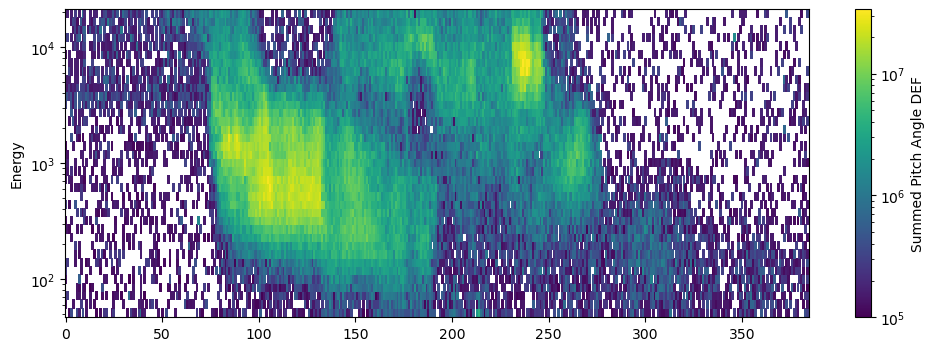

In [10]:

plt.figure(figsize=(12, 4))
plt.pcolor(np.arange(nt), subset_energies, subset_spect.T, norm=LogNorm())
plt.yscale('log')
plt.colorbar().set_label('Summed Pitch Angle DEF')
plt.ylabel('Energy')

$T=\int_{E_{min}_^{E_{max}} j(E) dE$

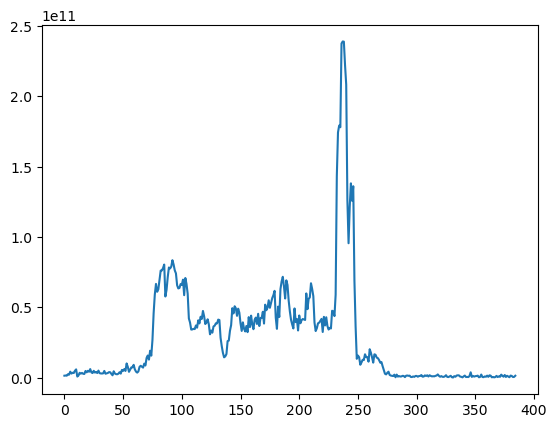

In [11]:


track = []

for i in range(nt):
    track.append(np.trapezoid(subset_spect[i, :], subset_energies))

plt.plot(np.arange(nt), track)

In [12]:

Eic = np.zeros(nt)
Eic[:] = np.nan

skip_threshold = 0.3e11
Eic_frac = 0.1

for i in range(nt):
    integ_flux = np.trapezoid(subset_spect[i, :], subset_energies)
    
    if integ_flux < skip_threshold:
        continue
    
    idx_peak_energy = np.argmax(subset_spect[i, :])
    j = idx_peak_energy
    
    while j >  0:
        if subset_spect[i, j] < Eic_frac * subset_spect[i, idx_peak_energy]:
            Eic[i] = subset_energies[j]
            break
        j -= 1
    

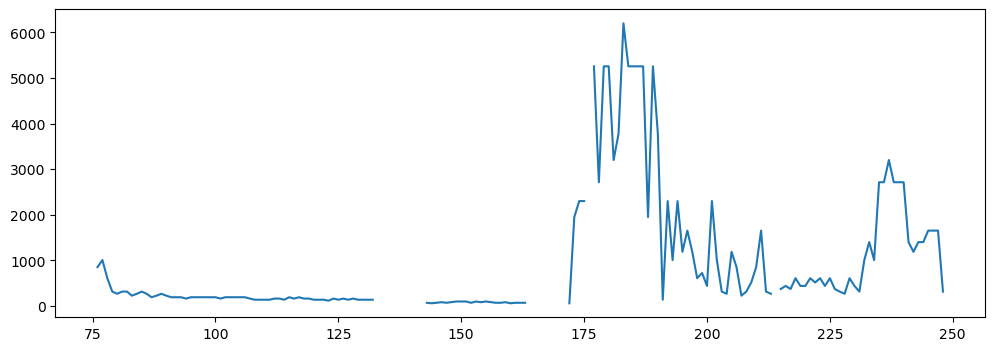

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(nt), Eic)

In [14]:
def clean_Eic(Eic,window_size=5):
    """Smooth Eic with a mask of points to include in moving average.
    
    Arguments
      Eic: floating point numpy array
      keep_mask: points to include in moving average
      window_size: integer, must be odd
    Returns
      Smoothed Eic array
    """    
    keep_mask= np.isfinite(Eic)
    assert (window_size is None) or (window_size % 2 == 1),\
        'Window size must be odd'

    Eic_clean = Eic.copy()
    
    for i in range(Eic.size):
        if not keep_mask[i]:
            Eic_clean[i] = np.nan
        elif (window_size is None) and keep_mask[i]:
            Eic_clean[i] = Eic[i]
        elif (window_size is not None):
            total = 0.0
            count = 0
            
            for di in range(-window_size//2, window_size//2 + 1):
                if i + di > 0 and i + di < Eic.size and keep_mask[i + di]:
                    total += Eic[i + di]
                    count += 1
            
            if count > 0:  # else left as nan
                Eic_clean[i] = total / count
                
    return Eic_clean

In [15]:
Eic_clean = clean_Eic(Eic)

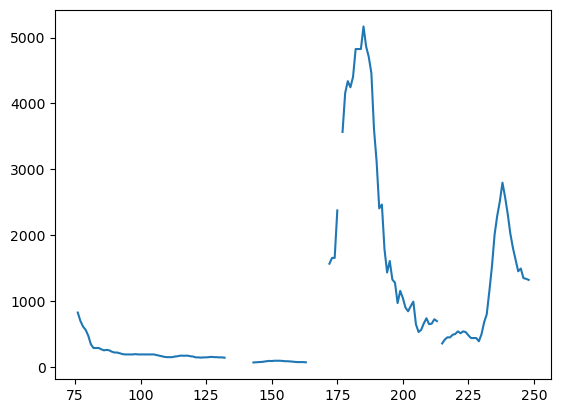

In [16]:
plt.plot(Eic_clean)

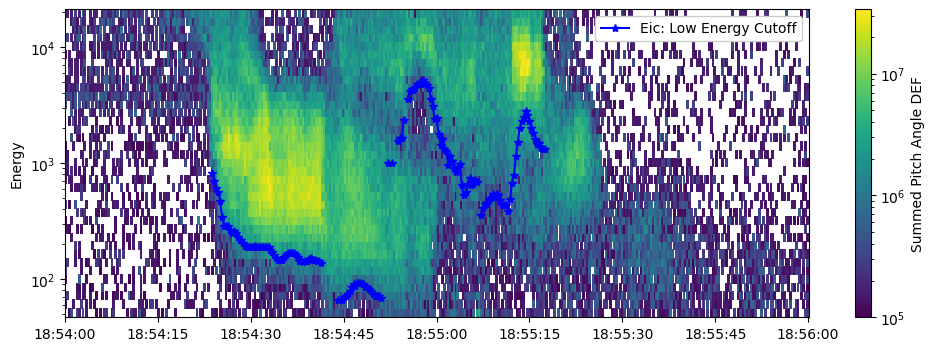

In [17]:

plt.figure(figsize=(12, 4))
plt.pcolor(subset_time, subset_energies, subset_spect.T, norm=LogNorm())
plt.plot(subset_time, Eic_clean, 'b*-', label='Eic: Low Energy Cutoff')
plt.yscale('log')
plt.colorbar().set_label('Summed Pitch Angle DEF')
plt.ylabel('Energy')
plt.legend(loc='upper right', framealpha=1)

In [18]:
mlat = -75 * np.ones(nt)
Eic_units = Eic_clean * units.eV
alpha = 0
d = 12

_, Ey_sat, Ey_mp = lib_lockwood1992.estimate_reconn_rate(
    subset_time,
    Eic_units,
    mlat,
    alpha,
    return_error=True,
    precip_travel_paths=[d],
    ignore_uncertain=True,
)

Bs at satellite 44649.89946966695 nT


Text(0.5, 0.98, 'Lockwood 1992 Reconnection Rate with TRACERS/ACI (TS1)')

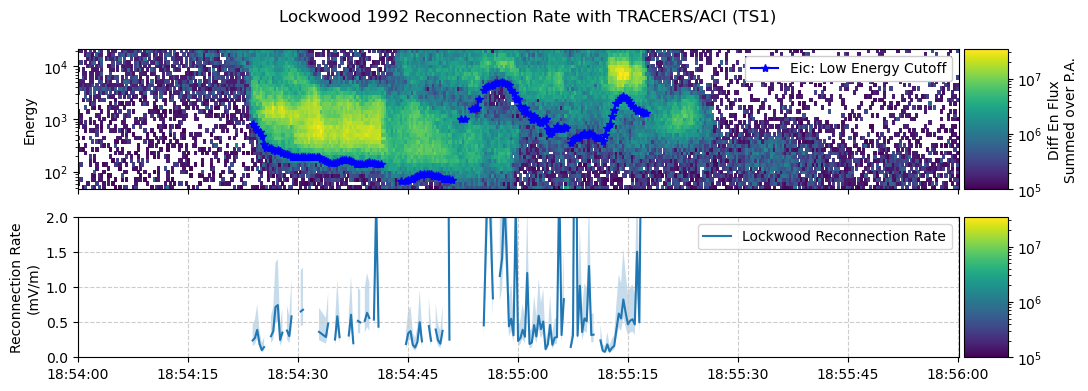

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
im = ax1.pcolor(subset_time, subset_energies, subset_spect.T, norm=LogNorm())
ax1.plot(subset_time, Eic_clean, 'b*-', label='Eic: Low Energy Cutoff')
ax1.set_yscale('log')
#ax1.colorbar().set_label('Summed Pitch Angle DEF')
ax1.set_ylabel('Energy')
ax1.legend(loc='upper right', framealpha=1)

ax2.plot(subset_time, Ey_mp['nominal'][0], label='Lockwood Reconnection Rate')
ax2.fill_between(subset_time, Ey_mp['err_low'][0], Ey_mp['err_high'][0], alpha=0.25)
ax2.set_ylim(0, 2)
ax2.set_ylabel('Reconnection Rate\n(mV/m)')
ax2.grid(color='#ccc', linestyle='dashed')
plt.legend()

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical').set_label('Diff En Flux\nSummed over P.A.')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

fig.suptitle('Lockwood 1992 Reconnection Rate with TRACERS/ACI (TS1)')